In [36]:
"""
General utils for training, evaluation and data loading
"""
import os
import torch
import pickle
import numpy as np
import torchvision.transforms as transforms

from PIL import Image

from torch.utils.data import BatchSampler
from torch.utils.data import Dataset, DataLoader

# General
BASE_DIR = ''
N_ATTRIBUTES = 312
N_CLASSES = 200

# Training
UPWEIGHT_RATIO = 9.0
MIN_LR = 0.0001
LR_DECAY_SIZE = 0.1

class CUBDataset(Dataset):
    """
    Returns a compatible Torch Dataset object customized for the CUB dataset
    """

    def __init__(self, pkl_file_paths, use_attr, no_img, uncertain_label, image_dir, n_class_attr, transform=None):
        """
        Arguments:
        pkl_file_paths: list of full path to all the pkl data
        use_attr: whether to load the attributes (e.g. False for simple finetune)
        no_img: whether to load the images (e.g. False for A -> Y model)
        uncertain_label: if True, use 'uncertain_attribute_label' field (i.e. label weighted by uncertainty score, e.g. 1 & 3(probably) -> 0.75)
        image_dir: default = 'images'. Will be append to the parent dir
        n_class_attr: number of classes to predict for each attribute. If 3, then make a separate class for not visible
        transform: whether to apply any special transformation. Default = None, i.e. use standard ImageNet preprocessing
        """
        self.data = []
        self.is_train = any(["train" in path for path in pkl_file_paths])
        if not self.is_train:
            assert any([("test" in path) or ("val" in path) for path in pkl_file_paths])
        for file_path in pkl_file_paths:
            self.data.extend(pickle.load(open(file_path, 'rb')))
        self.transform = transform
        self.use_attr = use_attr
        self.no_img = no_img
        self.uncertain_label = uncertain_label
        self.image_dir = image_dir
        self.n_class_attr = n_class_attr

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data = self.data[idx]
        img_path = img_data['img_path']
        
        # Trim unnecessary paths
        try:
            idx = img_path.split('/').index('CUB_200_2011')
            if self.image_dir != 'images':
                img_path = '/'.join([self.image_dir] + img_path.split('/')[idx+1:])
                img_path = img_path.replace('images/', '')
            else:
                img_path = '/'.join(img_path.split('/')[idx:])
            img = Image.open(img_path).convert('RGB')
        except:
            #img_path_split = img_path.split('/')
            #split = 'train' if self.is_train else 'test'
            #img_path = '/'.join(img_path_split[:2] + [split] + img_path_split[2:])
            
            img = Image.open(img_path).convert('RGB')

        class_label = img_data['class_label']
        if self.transform:
            img = self.transform(img)

        if self.use_attr:
            if self.uncertain_label:
                attr_label = img_data['uncertain_attribute_label']
            else:
                attr_label = img_data['attribute_label']
            if self.no_img:
                if self.n_class_attr == 3:
                    one_hot_attr_label = np.zeros((N_ATTRIBUTES, self.n_class_attr))
                    one_hot_attr_label[np.arange(N_ATTRIBUTES), attr_label] = 1
                    return one_hot_attr_label, class_label
                else:
                    return attr_label, class_label
            else:
                return img, class_label, attr_label
        else:
            return img, class_label


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices)

        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):  # Note: for single attribute dataset
        return dataset.data[idx]['attribute_label'][0]

    def __iter__(self):
        idx = (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))
        return idx

    def __len__(self):
        return self.num_samples

def load_data(pkl_paths, use_attr, no_img, batch_size, uncertain_label=False, n_class_attr=2, image_dir='images', resampling=False, resol=299):
    """
    Note: Inception needs (299,299,3) images with inputs scaled between -1 and 1
    Loads data with transformations applied, and upsample the minority class if there is class imbalance and weighted loss is not used
    NOTE: resampling is customized for first attribute only, so change sampler.py if necessary
    """
    resized_resol = int(resol * 256/224)
    is_training = any(['train.pkl' in f for f in pkl_paths])
    if is_training:
        transform = transforms.Compose([
            #transforms.Resize((resized_resol, resized_resol)),
            #transforms.RandomSizedCrop(resol),
            transforms.ColorJitter(brightness=32/255, saturation=(0.5, 1.5)),
            transforms.RandomResizedCrop(resol),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(), #implicitly divides by 255
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
            #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
            ])
    else:
        transform = transforms.Compose([
            #transforms.Resize((resized_resol, resized_resol)),
            transforms.CenterCrop(resol),
            transforms.ToTensor(), #implicitly divides by 255
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [2, 2, 2])
            #transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ], std = [ 0.229, 0.224, 0.225 ]),
            ])

    dataset = CUBDataset(pkl_paths, use_attr, no_img, uncertain_label, image_dir, n_class_attr, transform)
    if is_training:
        drop_last = True
        shuffle = True
    else:
        drop_last = False
        shuffle = False
    if resampling:
        sampler = BatchSampler(ImbalancedDatasetSampler(dataset), batch_size=batch_size, drop_last=drop_last)
        loader = DataLoader(dataset, batch_sampler=sampler)
    else:
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return loader

def find_class_imbalance(pkl_file, multiple_attr=False, attr_idx=-1):
    """
    Calculate class imbalance ratio for binary attribute labels stored in pkl_file
    If attr_idx >= 0, then only return ratio for the corresponding attribute id
    If multiple_attr is True, then return imbalance ratio separately for each attribute. Else, calculate the overall imbalance across all attributes
    """
    imbalance_ratio = []
    data = pickle.load(open(os.path.join(BASE_DIR, pkl_file), 'rb'))
    n = len(data)
    n_attr = len(data[0]['attribute_label'])
    if attr_idx >= 0:
        n_attr = 1
    if multiple_attr:
        n_ones = [0] * n_attr
        total = [n] * n_attr
    else:
        n_ones = [0]
        total = [n * n_attr]
    for d in data:
        labels = d['attribute_label']
        if multiple_attr:
            for i in range(n_attr):
                n_ones[i] += labels[i]
        else:
            if attr_idx >= 0:
                n_ones[0] += labels[attr_idx]
            else:
                n_ones[0] += sum(labels)
    for j in range(len(n_ones)):
        imbalance_ratio.append(total[j]/n_ones[j] - 1)
    if not multiple_attr: #e.g. [9.0] --> [9.0] * 312
        imbalance_ratio *= n_attr
    return imbalance_ratio

In [37]:
!pip install gdown

In [38]:
!gdown 1DUkovCVCUqYScle624llHyeUuC7t0SaN
!gdown 1oRBQ7WY_9-qfWkxNC7ZGBW27wecfEy6f
!gdown 1EsYvhX6aRDELjoKpcRo3fuLo-aKF6DI9
!gdown 1ir5HukW2XO25GWqx3jV-gKZWWi6Zg_rw

Downloading...
From (uriginal): https://drive.google.com/uc?id=1DUkovCVCUqYScle624llHyeUuC7t0SaN
From (redirected): https://drive.google.com/uc?id=1DUkovCVCUqYScle624llHyeUuC7t0SaN&confirm=t&uuid=a468d074-c75d-4ef2-8269-deba8a25d996
To: /kaggle/working/images.zip
100%|██████████████████████████████████████| 1.13G/1.13G [00:12<00:00, 89.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oRBQ7WY_9-qfWkxNC7ZGBW27wecfEy6f
To: /kaggle/working/kaggle_train.pkl
100%|█████████████████████████████████████████| 497k/497k [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EsYvhX6aRDELjoKpcRo3fuLo-aKF6DI9
To: /kaggle/working/kaggle_test.pkl
100%|█████████████████████████████████████████| 601k/601k [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ir5HukW2XO25GWqx3jV-gKZWWi6Zg_rw
To: /kaggle/working/kaggle_val.pkl
100%|████████████████████████████████████████| 124k/124k [00:00<00:00, 78.0MB/s]


In [39]:
import zipfile

with zipfile.ZipFile('./images.zip',"r") as z:
    z.extractall()

In [40]:
train_data_path="/kaggle/working/kaggle_train.pkl"
val_data_path="/kaggle/working/kaggle_val.pkl"

train_loader = load_data([train_data_path], use_attr=False, no_img=False, batch_size=64, uncertain_label=False, image_dir="", n_class_attr=0)
val_loader = load_data([val_data_path], use_attr=False, no_img=False, batch_size=64, uncertain_label=False, image_dir="", n_class_attr=0)

In [41]:
import torch
import torchvision
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 200)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [42]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [43]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

PATH = '/kaggle/working/'

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=1, beta=0.9):
  losses = []
  # Model save path
  p = "mode_tmp.pth"
  save_model(model, str(p))
  num = len(train_dl)-1
  mult = (lr_high / lr_low) ** (1.0/num)
  lr = lr_low
  avg_loss = 0.
  best_loss = 0.
  batch_num = 0
  log_lrs = []

  model.train()
  for i in range(epochs):
    for x,y in train_dl:
      batch_num +=1
      optim = get_optimizer(model, lr=lr)
      x = x.cuda().float()
      y = y.cuda().long()   
      out = model(x)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(out, y)

      #Compute the smoothed loss
      avg_loss = beta * avg_loss + (1-beta) *loss.item()
      smoothed_loss = avg_loss / (1 - beta**batch_num)

      #Stop if the loss is exploding
      if batch_num > 1 and smoothed_loss > 4 * best_loss:
        return log_lrs, losses

      #Record the best loss
      if smoothed_loss < best_loss or batch_num==1:
        best_loss = smoothed_loss
      #Store the values
      losses.append(smoothed_loss)
      log_lrs.append(math.log10(lr))

      optim.zero_grad()
      loss.backward()
      optim.step()
      #Update the lr for the next step
      lr *= mult
  load_model(model, str(p))
  return log_lrs, losses

In [50]:
def get_triangular_lr(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, 
                            lr_high=0.01, epochs = 4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_triangular_lr(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().long()
            out = model(x)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    val_loss = 0.0
    val_acc = 0.0
    val_size = 0
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().long()
            out = model(x)
            _, pred = torch.max(out, 1)
            correct += pred.eq(y.data).sum().item()
            y = y.long()
            criterion = nn.CrossEntropyLoss()
            loss = criterion(out, y)
            sum_loss += batch*(loss.item())
            total += batch

            val_acc += accuracy_score(pred.cpu().numpy(), y.cpu().numpy()) * x.size(0)
            val_size += x.size(0)

    
    val_acc /= val_size
    print("val loss and accuracy", sum_loss/total, correct/total)
    print(f'Val accuracy: {val_acc}')

Training loop

In [45]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-6, lr_high=0.01, epochs = 4):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [46]:
model = Net().cuda()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finding best learning rate(keeping 7 layers freezed)

In [47]:
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-6, lr_high=0.1)

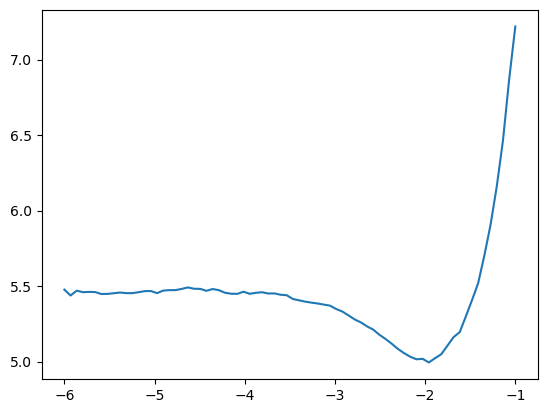

In [48]:
plt.plot(lrs, losses)
plt.show()

In [51]:
val_metrics(model, val_loader)

val loss and accuracy 5.3329573003995 0.0025041736227045075
Val accuracy: 0.0025041736227045075


In [52]:
training_loop(model, train_loader, val_loader, steps=1, lr_low= 1e-3, lr_high=1*1e-2, epochs = 16)

train loss 4.904511032877742
val loss and accuracy 4.73362044858216 0.15776293823038398
Val accuracy: 0.15776293823038398
train loss 4.785041106713785
val loss and accuracy 4.627370037499174 0.1310517529215359
Val accuracy: 0.1310517529215359
train loss 4.671918482393832
val loss and accuracy 4.627094315766094 0.11185308848080133
Val accuracy: 0.11185308848080133
train loss 4.567491576478288
val loss and accuracy 4.405420488029569 0.13689482470784642
Val accuracy: 0.13689482470784642
train loss 4.529485470539814
val loss and accuracy 4.340383694446545 0.13606010016694492
Val accuracy: 0.13606010016694492
train loss 4.476857033935753
val loss and accuracy 4.349665819305012 0.15108514190317196
Val accuracy: 0.15108514190317196
train loss 4.262546909822
val loss and accuracy 4.0403770094920874 0.2045075125208681
Val accuracy: 0.2045075125208681
train loss 4.123757475131267
val loss and accuracy 4.144068095043227 0.18697829716193656
Val accuracy: 0.18697829716193656
train loss 4.1100302354

In [53]:
p = "model1_tmp.pth"
save_model(model, str(p))
load_model(model, str(p))

def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b
        
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

Unfreezeing 3 top layers of resnet and retraining again

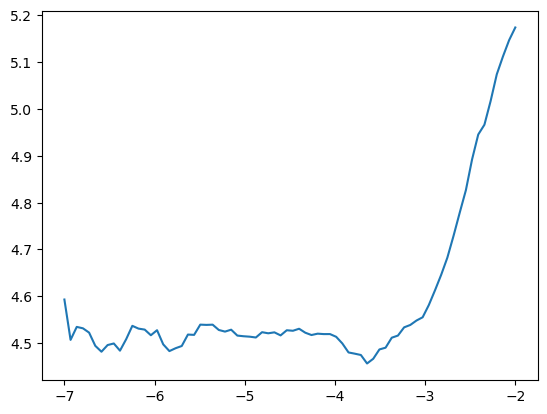

In [54]:
unfreeze(model, 7)
unfreeze(model, 6)
unfreeze(model, 5)

#New
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-7, lr_high=0.01)
plt.plot(lrs, losses)
plt.show()

In [55]:
training_loop(model, train_loader, val_loader, steps=1, lr_low= 1e-6, lr_high=1*1e-3, epochs = 30)

train loss 4.466170433405283
val loss and accuracy 4.532305144308405 0.2328881469115192
Val accuracy: 0.2328881469115192
train loss 4.3847432265410555
val loss and accuracy 4.564084752772208 0.21869782971619364
Val accuracy: 0.21869782971619364
train loss 4.31407550218943
val loss and accuracy 4.667500617707114 0.19782971619365608
Val accuracy: 0.19782971619365608
train loss 4.287282157588649
val loss and accuracy 4.509029878797834 0.20784641068447413
Val accuracy: 0.20784641068447413
train loss 4.310053039241481
val loss and accuracy 4.6150311317189106 0.21452420701168615
Val accuracy: 0.21452420701168615
train loss 4.293694831229545
val loss and accuracy 4.5113050742619025 0.22370617696160267
Val accuracy: 0.22370617696160267
train loss 4.26846102121714
val loss and accuracy 4.764503457510411 0.1652754590984975
Val accuracy: 0.1652754590984975
train loss 4.263488112269221
val loss and accuracy 4.983233331638903 0.18113522537562604
Val accuracy: 0.18113522537562604
train loss 4.224511

In [56]:
p = "model2.pth"
save_model(model, str(p))

load_model(model, str(p))


Unfreezing more layers and retraining 

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the model to evaluation mode
model.eval()
model = model.to(device)
loss_fn=nn.CrossEntropyLoss()

# Evaluate one epoch
val_loss = 0.0
val_acc = 0.0
val_size = 0
with torch.no_grad():
    for images, labels in val_loader:
        # Move the data to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Update the validation loss and accuracy
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_acc += accuracy_score(preds.cpu().numpy(), labels.cpu().numpy()) * images.size(0)
        val_size += images.size(0)

val_loss /= val_size
val_acc /= val_size

In [60]:
print(val_acc)

0.7662771285475793
